## Imports

In [3]:
import numpy as np
import pandas as pd
import swifter
# import pandas_profiling
import pprint
import requests
import pickle

import time

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint, Point, shape
import seaborn as sns; sns.set()

## Jupyter Configurations

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)

%matplotlib inline

## Definitions

In [5]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    print('DBSCAN_Reduce started: ', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
#     coords = df.as_matrix(columns=[y, x]) # Deprecated
    coords = df[[y, x]].values
    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine',n_jobs=-1).fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters found: {:,}'.format(num_clusters))
    
    print('Building clusters started: ', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    print('Cluster centering started: ', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    print('Gathering cluster centers: ', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

## Read Data

In [6]:
%%time

infile = open('US_Accidents_Dec19', 'rb')
df = pickle.load(infile)
infile.close()

print('Imported {:,} rows.'.format(len(df)))

Imported 2,974,335 rows.
CPU times: user 2.66 s, sys: 1.28 s, total: 3.95 s
Wall time: 3.94 s


# Cluster by GPS coordinates
## Remove rows where the Longitude and/or Latitude are null values

In [7]:
%%time

df.dropna(axis=0,how='any',subset=['Start_Lat','Start_Lng'],inplace=True)

CPU times: user 2.7 s, sys: 536 ms, total: 3.24 s
Wall time: 1.65 s


In [ ]:
%%time 
#37 min, 33s for DBSCAN of full data set as 1km

# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 1 / kms_per_radian
df_clustered = dbscan_reduce(df, epsilon=eps_rad, x='Start_Lng', y='Start_Lat')

DBSCAN_Reduce started:  2020-04-08 19:46:57


In [ ]:
%%time

# next, sample every nth row (where n=sample_rate) of the full gps location history data set
# sample_rate = 20
# df_sampled = df.iloc[range(0, len(df), sample_rate)]

# sample a percentage of the full gps location data set
df_sampled = df.sample(frac = 0.05, replace = False, random_state = 42)
len(df_sampled)

df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.1 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad, x='Start_Lng', y='Start_Lat')

NameError: name 'df_final' is not defined

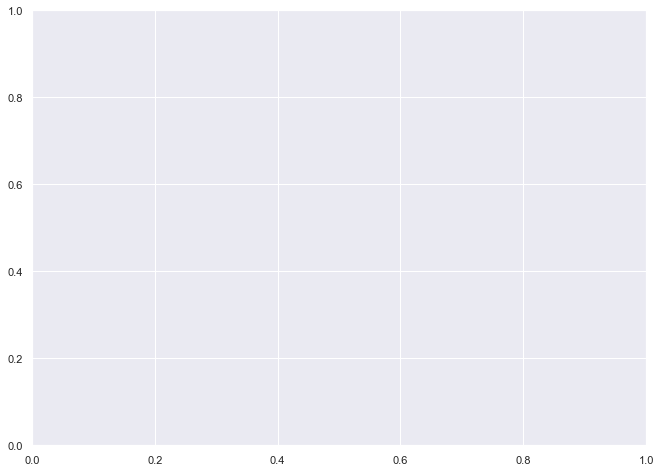

In [8]:
%%time

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['Start_Lng'], df_final['Start_Lat'], c='m', edgecolor='None', alpha=0.3, s=120)
# df_scatter = ax.scatter(df['Start_Lng'], df['Start_Lat'], c='k', alpha=0.5, s=3)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([rs_scatter], ['Reduced set'], loc='upper right')
plt.show()

NameError: name 'df_final' is not defined

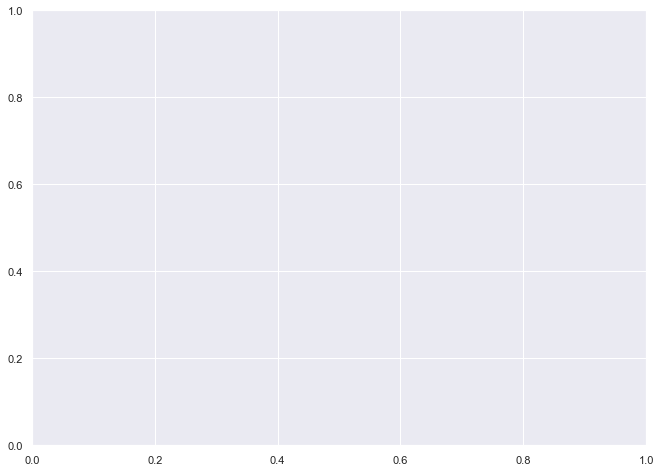

In [9]:
%%time

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['Start_Lng'], df_final['Start_Lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df['Start_Lng'], df['Start_Lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()